# Компьютерные игры для продажи в Интернет-магазине

### Описание проекта и постановка задачи.

Заказчиком является Интернет-магазин, торгующий компьютерными играми. Из открытых источников им представлены исторические данные о продажах игр, оценках пользователей и экспертов, жанрах и платформах. На их основании нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Необходимо по данным текущего года спланировать компанию на следующий год, отработать принцип работы с данными, выявить закономерности.

### план работы:

Главная цель работы: выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
1. Подключим необходимые для работы библиотеки, из представлено файла получим исходную выборку в виде датафрейма.
2. Подготовим данные - заполним пропуски, где это возможно. В случае необходимости поменяем тип данных.
3. Получим распределение выпущенных игр по году выпуска, определим актуальный период выпуска игр, выясним срок жизни игровой платформы.
4. Распределение выпущенных игр по платформам, жанрам.
5. Распределение продаж игр по платформам, жанрам. Определим, как влияют оценки пользователей и критиков на продажи.
6. Составим клинтский профиль для пользователя из Северной Америки, Европы, Японии.
7. Составим гипотезы и проверим их.
8. Подготовим общие выводы и ответим на вопрос заказчика.

### подключение библиотек

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import random
import matplotlib.pyplot as plt
import math
import seaborn as sns

## 1. Получение файлов с данными, изучение общей информации

In [2]:
games = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
games.columns = games.columns.str.lower()
#games.columns = ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### общая информация по выборке

1. Выборка представлена таблицей из 11 колонок и 16715 строк.
2. В каждой строке описывается компьютерная игра. В колонках таблицы содержатся следующие сведения об игре: её имя, платформа размещения, год выпуска, жанр, продажи (в миллионах проданных копий) - в Северной Америке, Европе, Япаноии, других странах, оценка игры - критиков, пользователей, её рейтинг от организации ESRB.
3. В полученной таблице поля названы некорректно и были переименованы.

## 2. Подготовка данных

### поиск и обработка дубликатов:

In [4]:
#Поиск полных дубликатов в таблице:
print('число полных дубликатов в таблице:', games.duplicated().sum())

число полных дубликатов в таблице: 0


полных дубликатов не обнаружено

### колонка таблицы name - название игры

для корректной обработки - поиска дубликатов, в этом поле приведём все названия к нижнему регистру.

In [5]:
games['name'] = games['name'].str.lower()
print(games['name'].duplicated().sum())

display(games.loc[games['name'].isnull()])

games.dropna(subset = ['name'], inplace = True)
print(games['name'].duplicated().sum())

5155


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


5154


в колонке имеется 5155 дубликатов - это игры, представленные версиями для разных плаформ, с разными годами переиздания, и по своей сути - дубликатами не являются, какждая такая строка - отдельной товарной позицией.

В столбце имеется 2 пропуска - 2 игры 1993 года выпуска. Вероятно, когда формировалась выборка, правильные названия таких игр составителями не были найдены. Информативность этих строк минимальная - указаны продажи и платформа, рейтинги и жанр отсутствуют.

Эти записи искажений в расчёты не добавят, но и, если их удалить, тоже ничего страшного. Выяснить названия на основании представленных данных не представляется возможным. Я их удаляю.

### колонка таблицы genre - жанр игры

In [6]:
display(games['genre'].value_counts().sort_values(ascending=False))
print('пропущенных значений в поле:', games['genre'].isnull().sum())

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

пропущенных значений в поле: 0


пропуски в поле отсутствуют, задвоенных значений (обозначающих одно и тоже), не выявлено. Дополнительная обработка полю не требуется.

### колонка таблицы user_score - оценка пользователями

Абвеатура tbd в этом столбце user_score обозначает "будет определен". Так как по параметру будут производится расчёты, тип поля нужно преобразовать из строкового в вещественный. Значение tbd нужно заменить на NaN, что бы не получить искажение в расчётах.

Пропуски могли появится по причине, что составители просто не нашли соответствующие данные, либо - такие просто отсутствуют - статистику по игре для конкретной платформы, для года перевыпуска, могли и не собрать.

Заменять на 0 не нужно. Выяснить, чем заменить пропуски на основании представленных в выборке сведений, не возможно, а нули в этом поле могут значительно исказить результаты обработки и конечные выводы.

In [7]:
games['user_score'] = games['user_score'].replace('tbd', np.nan)

games['user_score'] = games['user_score'].replace('tbd', np.nan)
games['user_score'] = games['user_score'].astype('float')

### колонка таблицы critic_score - оценка критиками       

In [8]:
print('число пропусков в поле:', games['critic_score'].isnull().sum())

число пропусков в поле: 8576


ситуация, аналогичная с полем user_score - отсутствуют соответствующие данные. Логично пропуски оставить не заполненными. Тип данных - вещественные числа, который нужен для рассчётов. Поле не требует дополнительной обработки.

### колонка таблицы year_of_release - год выпуска

In [9]:
#display(games.query('year_of_release.isnull()').head())
display(games.loc[games['year_of_release'].isnull()].head())
print()
print(games['year_of_release'].isnull().sum())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,madden nfl 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,fifa soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,lego batman: the videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe smackdown vs. raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,space invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN



269


пропусков - 269. Относительно общего числа строк не много, но для максимального сохранения данных выборки - строки с пропусками в этом поле постараемся сохранить.

Пропуски носят не систематический характер, и, скорее всего, получились из-за человеческого фактора - оператор, заполнявший таблицу, забыл указать значение.

Логично предположить, что игра, где пропущен год релиза, выпущена в год, когда было создано максимальное колличество игр для её платформы и в ёё жанре. (так называемая мода)

Колонка имеет тип вещественных чисел. Можно оставить, но здесь лучше будет смотреться целочисленный тип.

### колонка таблицы rating - возрастная категория от ESRB

In [10]:
print('число пропусков в поле:', games['rating'].isnull().sum())
print('уникальные значения поля:', games['rating'].unique())
print()
games['rating'] = games['rating'].replace('K-A', 'E')
games['rating'] = games['rating'].replace('RP', np.nan)
games['rating'] = games['rating'].replace(np.nan, 'absent')
print('значения поля и число строк с этими значениями после обработки:')
display(games.groupby('rating')['name'].count())

число пропусков в поле: 6764
уникальные значения поля: ['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']

значения поля и число строк с этими значениями после обработки:


rating
AO           1
E         3993
E10+      1420
EC           8
M         1563
T         2961
absent    6767
Name: name, dtype: int64

пропущенных значений в поле - 6764. Пропуски в этой колонке скорее всего появились по причине того, что не каждая игра и не на каждой платформе оцениваются ESRB. Нужно заметить, что эта организация действует на территории США и Канады.

Достоверно заполнить пропущенные значения на основании представленных в выбоке данных не представляется возможным. Но, далее пропуски в этой колонке так же нужно будет обрабатывать. Присвоим им значение absent - не существующее.

При рассмотрении значений найдено "K-A", которое несёт такую же смысловую нагрузку, что и значение "Е", поэтому, такие записи перезаписаны на "Е".

Так-же, "RP" обозначены игры, принятые на рассмотрение в ESRB, но итоговый рейтинг получить еще не успели. Возрастная категория таких игр не определена, что так-же соответствует пропущеному значению. Логично заменить RP на NaN. 

### колонки таблицы sales - число проданных копий в миллионах по регионам мира

пропуски в этих столбцах отсутствуют, данные имеют нужный для расчётов тип - вещественные числа. Дополнительная обработка не требуется.

### создание колонки с общим числом проданных копий

In [11]:
games['sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

### итоги подготовки данных:

In [12]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           16713 non-null  object 
 11  sales            16713 non-null  float64
dtypes: float64(8), object(4)
memory usage: 1.7+ MB


1. Выборка проверена на наличие полных дубликатов - таковых найдено не было.
2. Рассмотрены все колонки таблицы.
3. Удалены строки, не представляющие интереса для дальнейших рассчётов - информационный мусор.
4. Проведена работа с пропусками: высказаны предположения их возникновения, определена необходимость их заполнения, где уместно - заполнены наиболее подходящими значениями. 
5. В полях убраны задвоенные значения - обозначающие одно и тоже разными терминами.
6. Где это необходимо - изменён тип данных.

Выбрка готова для дальнейшей работы.

## 3. Исследовательский анализ данных.

#### 3.1. Распределение игр по годам выпуска.

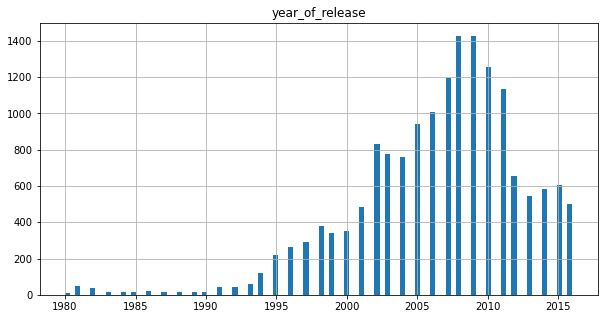

In [13]:
games.hist('year_of_release', bins=100, figsize=(10, 5), grid=True)
plt.show()

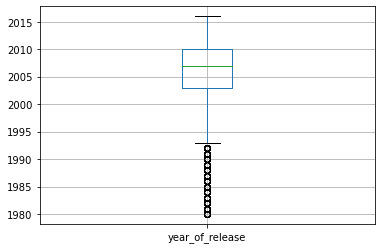

In [14]:
games.boxplot('year_of_release')
plt.show()

In [15]:
count_years = games['year_of_release'].value_counts().sort_values(ascending=False)
display(count_years)

2008.0    1427
2009.0    1426
2010.0    1255
2007.0    1197
2011.0    1136
2006.0    1006
2005.0     939
2002.0     829
2003.0     775
2004.0     762
2012.0     653
2015.0     606
2014.0     581
2013.0     544
2016.0     502
2001.0     482
1998.0     379
2000.0     350
1999.0     338
1997.0     289
1996.0     263
1995.0     219
1994.0     121
1993.0      60
1981.0      46
1992.0      43
1991.0      41
1982.0      36
1986.0      21
1989.0      17
1983.0      17
1990.0      16
1987.0      16
1988.0      15
1985.0      14
1984.0      14
1980.0       9
Name: year_of_release, dtype: int64

Больше всего игр было выпущено в 2008-2009 годах. В соответствии с графиком boxplot данные об играх, выпущенных до 1993 года - не типичны, подходят под определение выбросов. Конечно же, сведения за все года не могут являться актуальными.

#### 3.2. Определение периода актуальных данных по играм.

Для определении периода, в течении которого сведения об изданных играх являются актуальными, логично предположить, что наиболее встребованными из них будут разработанные для актуальных игровых платформ на момент формирования выборки, то есть - на 2016-ый год. Для определения начала этого срока нужно взять одну из таких платформ с самым длинным периодом использования. Его начало и будет началом актуального периода. Таким образом, из рассчётов выпадут архивные игровые платформы.

Для определения актуального периода создадим отдельный датафрейм, где в колонках укажем:
1. Названия платформы. 
2. Её минимальный год,
3. Максимальный год для платформы.
4. Продолжительность жизни платформы в годах. Вычислим по формуле: max - min + 1.

После чего отберём платформы с максимальным годом 2016, и из них отберём самое большое значение продолжительности жизни. Полeчим актуальный период для дальнейшего использования.

In [16]:
liv_platform = pd.DataFrame()

i = 0
for vol in games['platform'].unique():
    liv_platform.loc[i, 'platform'] = vol
    liv_platform.loc[i, 'min'] = games.query('platform == @vol')['year_of_release'].min()
    liv_platform.loc[i, 'max'] = games.query('platform == @vol')['year_of_release'].max()
    liv_platform.loc[i, 'duration'] = liv_platform.loc[i, 'max'] - liv_platform.loc[i, 'min'] + 1
    i = i + 1

arh_platform = liv_platform

#liv_platform = liv_platform.query('max == 2016.0')
liv_platform = liv_platform.loc[liv_platform['max'] == 2016.0]
display(liv_platform)

,platform,min,max,duration
0,Wii,2006.0,2016.0,11.0
4,X360,2005.0,2016.0,12.0
5,PS3,2006.0,2016.0,11.0
9,PS4,2013.0,2016.0,4.0
10,3DS,2011.0,2016.0,6.0
14,PC,1985.0,2016.0,32.0
17,XOne,2013.0,2016.0,4.0
18,WiiU,2012.0,2016.0,5.0
22,PSV,2011.0,2016.0,6.0


из полученной таблицы актуальных платформ выделяется PC - персональный компьютер. Версии игр для PC выпускались практически на протяжении всего периода, охваченного исходной выборкой. Эту платформу удаляем, и получаем искомый актуальный период. 

In [17]:
# из полученой выборки необходимо убрать платформу PC - игры для настольных компьютеров
p = 'PC'
#liv_platform = liv_platform.query('platform != @p').sort_values(by='duration', ascending=False).reset_index()
liv_platform = liv_platform.loc[liv_platform['platform'] != p].sort_values(by='duration', ascending=False).reset_index()
del liv_platform['index']

display(liv_platform)

end = 2016
#begin = int(end - liv_platform['duration'].max() + 1)
begin = 2011

print('актуальный период:', begin, '-', end)

,platform,min,max,duration
0,X360,2005.0,2016.0,12.0
1,Wii,2006.0,2016.0,11.0
2,PS3,2006.0,2016.0,11.0
3,3DS,2011.0,2016.0,6.0
4,PSV,2011.0,2016.0,6.0
5,WiiU,2012.0,2016.0,5.0
6,PS4,2013.0,2016.0,4.0
7,XOne,2013.0,2016.0,4.0


актуальный период: 2011 - 2016


приведём исходную выборку к полученному актуальному периоду:

In [18]:
games_aktuality = games.query('year_of_release >= @begin')
print(games_aktuality['year_of_release'].min())
print(games_aktuality['year_of_release'].max())

2011.0
2016.0


##### Определение срока жизни игровых платформ.

Для расчёта этого параметра нужно взять сведения по архивным платформам, которые в 2016 году уже не использовались. Данные по действующим на 2016 год платформам для этого не подходят, так как они ещё не "умерли", и срок жизни их не известен.

Так же в расчёт не стоит брать данные по играм, выпущенным до 1993 года, в соответствии с построенным выше боксплотом - это выбросы и искажают данные по общей выборке.

Для этого используем таблицу  arh_platform, полученную выше, и обрабатываем её в соответствии с этими условиями.

In [19]:
#arh_platform = arh_platform.query('min > 1993 and max < 2016').reset_index()

arh_platform = arh_platform.loc[(arh_platform['min'] > 1993) & (arh_platform['max'] < 2016)].reset_index()

del arh_platform['index']
display(arh_platform)
print('продолжительность жизни игровой платформы:', arh_platform['duration'].min(), '-', arh_platform['duration'].max())
print('средняя продолжительность жизни:', arh_platform['duration'].mean())
print('медианная продолжительность жизни:', arh_platform['duration'].median())

,platform,min,max,duration
0,PS2,2000.0,2011.0,12.0
1,GBA,2000.0,2007.0,8.0
2,N64,1996.0,2002.0,7.0
3,PS,1994.0,2003.0,10.0
4,XB,2000.0,2008.0,9.0
5,PSP,2004.0,2015.0,12.0
6,GC,2001.0,2007.0,7.0
7,DC,1998.0,2008.0,11.0
8,SAT,1994.0,1999.0,6.0
9,WS,1999.0,2001.0,3.0


продолжительность жизни игровой платформы: 1.0 - 12.0
средняя продолжительность жизни: 6.846153846153846
медианная продолжительность жизни: 7.0


1. Таким образом, игровая платформа живёт в среднем 7 лет.
2. Продолжительность жизни игровых платформ увеличивается.

#### 3.3. Анализ продаж по платформам.

данные для рассчётов берём из актуализированной версии исходной выборки.

platform
PS3     445.57
X360    380.38
PS4     314.14
3DS     257.81
XOne    159.32
PC       97.68
Wii      95.02
WiiU     82.19
PSV      53.81
DS       38.73
PSP      29.01
PS2       0.45
Name: sales, dtype: float64

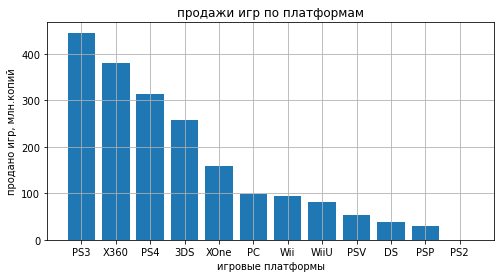

In [20]:
platform_sales = games_aktuality.groupby('platform')['sales'].sum().sort_values(ascending=False)
display(platform_sales)

plt.figure(figsize=(8, 4))
plt.grid(True)
plt.title('продажи игр по платформам')
plt.xlabel('игровые платформы')
plt.ylabel('продано игр, млн.копий')
plt.bar(platform_sales.index, platform_sales)
plt.show()

как видно из полученного результата, больше всего продано игр на расскрученных платформах, которые живут долго, на них разработано много игр, в основном это - актуальные платформы. Х360 - срок жизни 12 лет PS3 - срок жизни 11 лет- 1-ое место по числу проданных копий, Х360 - срок жизни 12 лет - 2-ое место. Обе они актуальны на 2016 год. Так же, в данном рейтинге представлены и не актуальные платформы, но по числу проданных копий игр за актуальный период они расположены в самом конце.

##### Распределение продаж по годам выпуска игр для каждой платформы.

посмотрим, как меняется объём продаж с течением времени по платформам. Определим, где продажи падают, а где - затухают.

*************************************************************************************

1. Pаспределение по игровой платформе PS3


year_of_release
2011.0    156.78
2012.0    107.36
2013.0    113.25
2014.0     47.76
2015.0     16.82
2016.0      3.60
Name: sales, dtype: float64

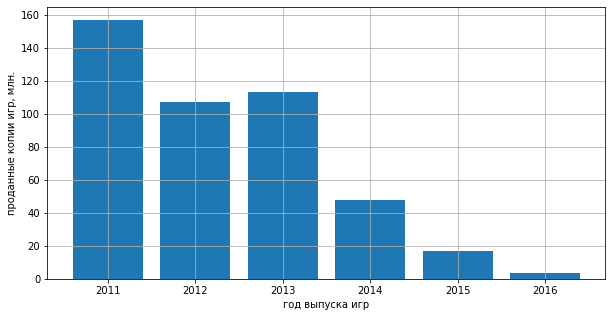

*************************************************************************************

2. Pаспределение по игровой платформе X360


year_of_release
2011.0    143.84
2012.0     99.74
2013.0     88.58
2014.0     34.74
2015.0     11.96
2016.0      1.52
Name: sales, dtype: float64

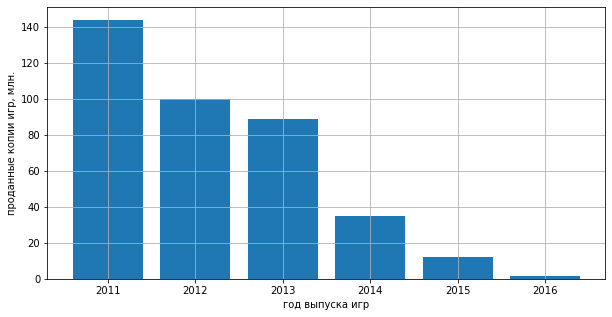

*************************************************************************************

3. Pаспределение по игровой платформе PS4


year_of_release
2013.0     25.99
2014.0    100.00
2015.0    118.90
2016.0     69.25
Name: sales, dtype: float64

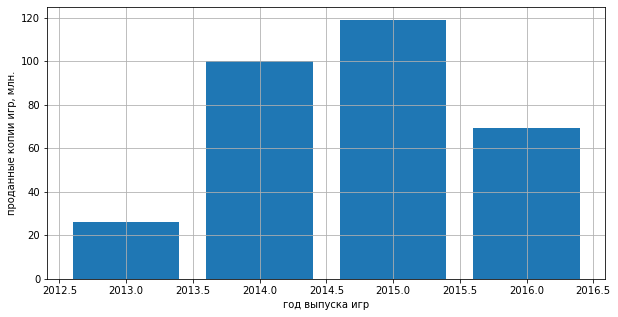

*************************************************************************************

4. Pаспределение по игровой платформе 3DS


year_of_release
2011.0    63.20
2012.0    51.36
2013.0    56.57
2014.0    43.76
2015.0    27.78
2016.0    15.14
Name: sales, dtype: float64

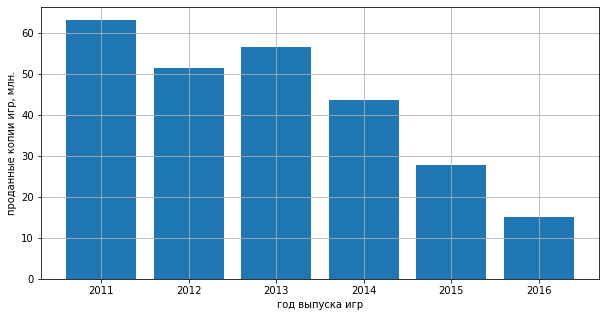

*************************************************************************************

5. Pаспределение по игровой платформе XOne


year_of_release
2013.0    18.96
2014.0    54.07
2015.0    60.14
2016.0    26.15
Name: sales, dtype: float64

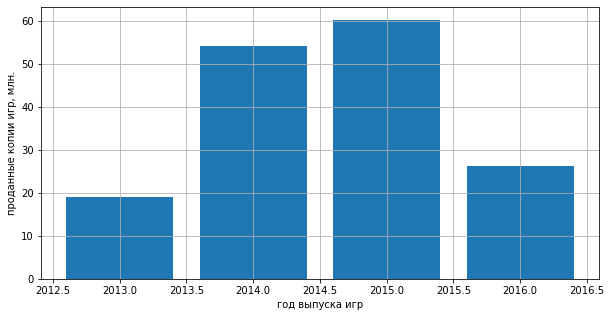

*************************************************************************************

6. Pаспределение по игровой платформе PC


year_of_release
2011.0    35.03
2012.0    23.22
2013.0    12.38
2014.0    13.28
2015.0     8.52
2016.0     5.25
Name: sales, dtype: float64

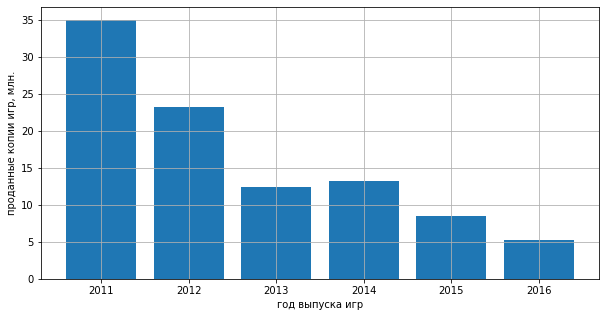

*************************************************************************************

7. Pаспределение по игровой платформе Wii


year_of_release
2011.0    59.65
2012.0    21.71
2013.0     8.59
2014.0     3.75
2015.0     1.14
2016.0     0.18
Name: sales, dtype: float64

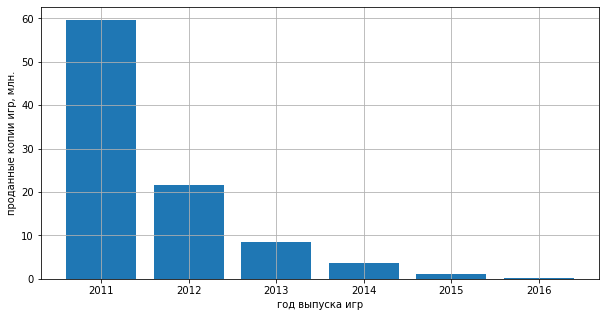

*************************************************************************************

8. Pаспределение по игровой платформе WiiU


year_of_release
2012.0    17.56
2013.0    21.65
2014.0    22.03
2015.0    16.35
2016.0     4.60
Name: sales, dtype: float64

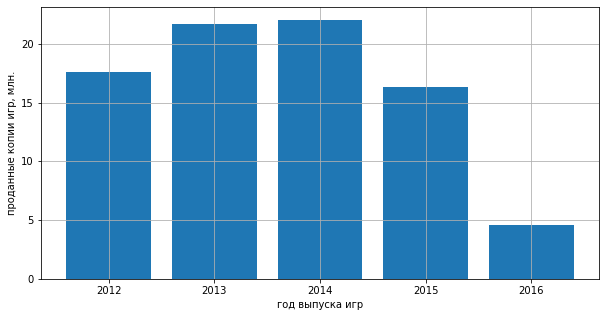

*************************************************************************************

9. Pаспределение по игровой платформе PSV


year_of_release
2011.0     4.63
2012.0    16.19
2013.0    10.59
2014.0    11.90
2015.0     6.25
2016.0     4.25
Name: sales, dtype: float64

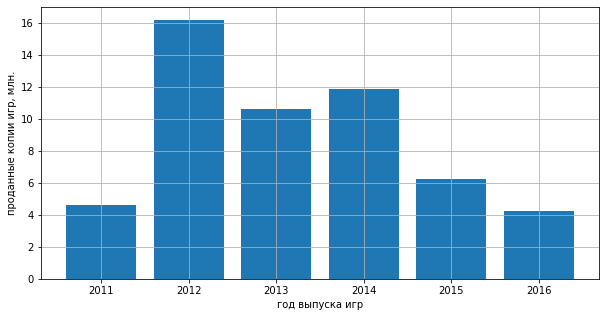

*************************************************************************************

10. Pаспределение по игровой платформе DS


year_of_release
2011.0    26.18
2012.0    11.01
2013.0     1.54
Name: sales, dtype: float64

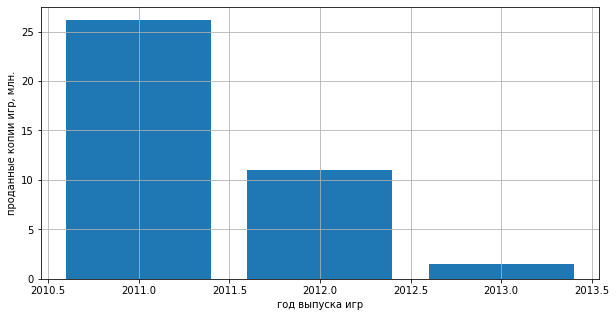

*************************************************************************************

11. Pаспределение по игровой платформе PSP


year_of_release
2011.0    17.82
2012.0     7.69
2013.0     3.14
2014.0     0.24
2015.0     0.12
Name: sales, dtype: float64

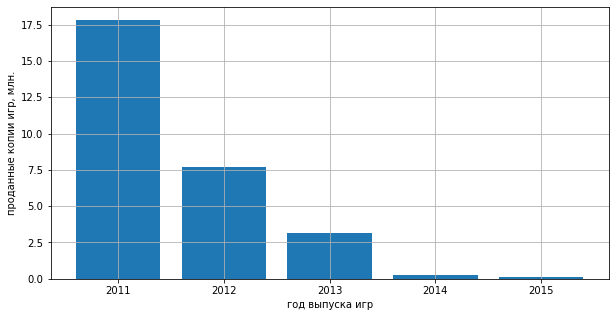

*************************************************************************************

12. Pаспределение по игровой платформе PS2


year_of_release
2011.0    0.45
Name: sales, dtype: float64

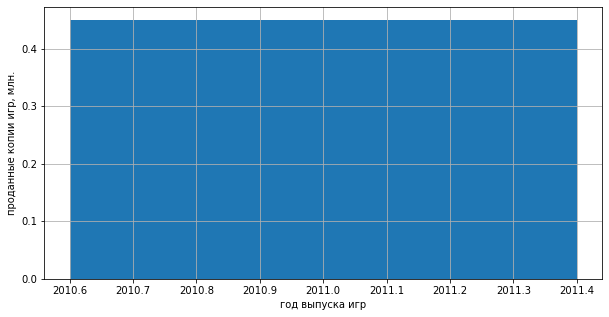

*************************************************************************************



In [21]:
print('*************************************************************************************')
print()
i = 1
for val in platform_sales.index:
    table = games_aktuality.query('platform == @val').groupby('year_of_release')['sales'].sum()
    print(str(i)+'.', 'Pаспределение по игровой платформе', val)
    i = i + 1
    display(table)
    
    plt.figure(figsize=(10, 5))
    plt.xlabel('год выпуска игр')
    plt.ylabel('проданные копии игр, млн.')
    plt.grid(True)
    plt.bar(table.index, table)
    plt.show()
    
    print('*************************************************************************************')
    print()

по результатам этого исследования можно сказать, что:
1. На платформах - лидерах продаж в основном продаются игры 2011-2013 года выпуска. Это происходит по двум причинам: игра на популярной платформе за это время (4-5 лет) успевает стать известной, зарекомендовать себя. В указанные годы игр выпускалось значительно больше, чем в другие периода.
2. Продажи игр на платформах лидерах-продаж начиная с указанных годов падают. Как указывалось выше, такие игровые платформы имеют солидный возраст. У них имеется свой жизненный цикл, и у лидеров продаж он подходит к завершению. Производители игр зная это, с каждым годом всё  меньше разрабатывают для них игр. Вторая причина - новые игры просто не успевают расскрутится.
3. На относительно новых игровых платформах PS4, XOne, WiiU, срок жизни которых 4 - 5 лет, продажи игр по годам практически не падают, а в некоторых случаях даже наблюдается рост продаж. (Такое ощущение, что данные по 2016 году собраны не полностью.) 
    

##### Построение диаграмм размаха глобальных продаж по актуальным игровым платформам

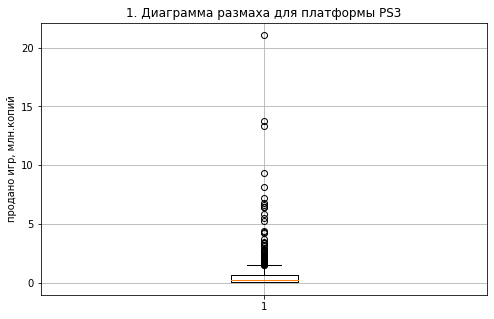

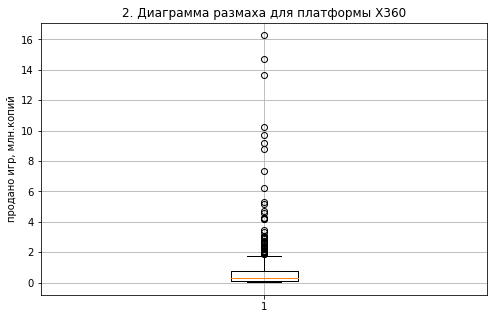

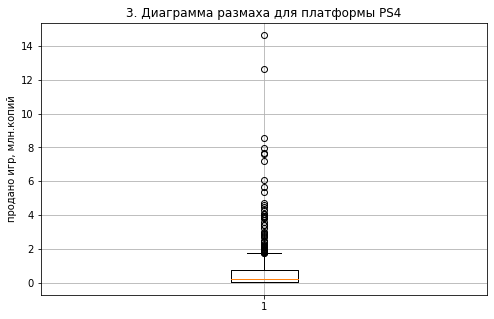

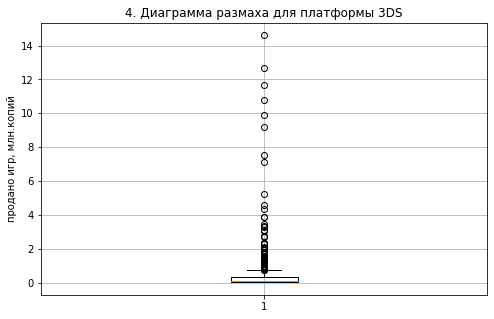

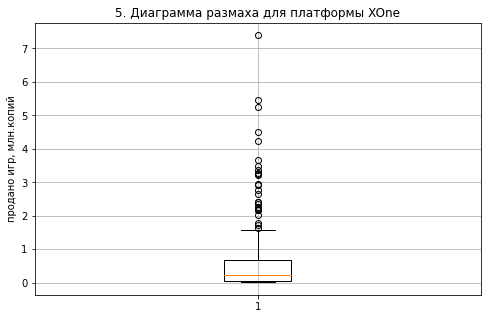

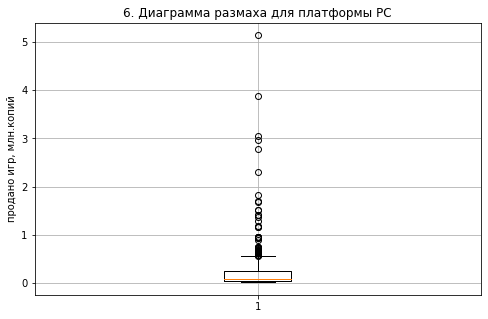

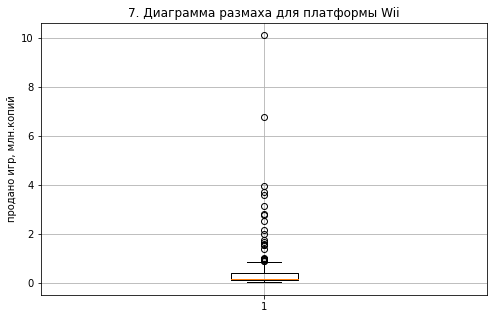

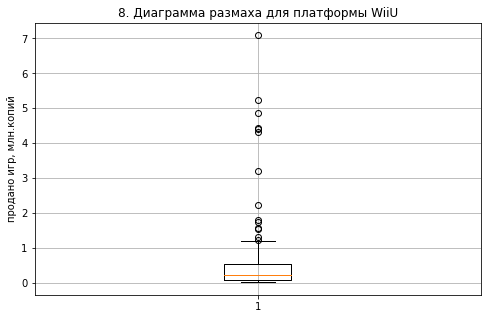

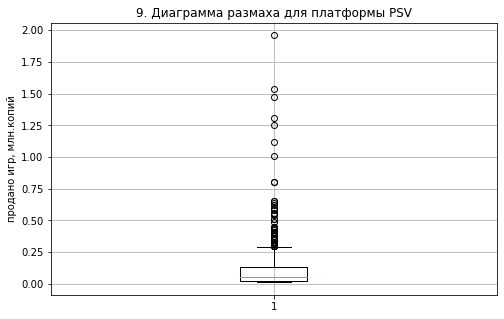

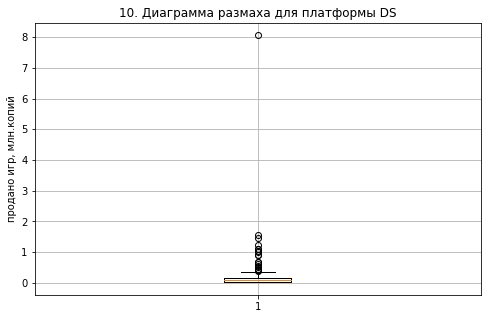

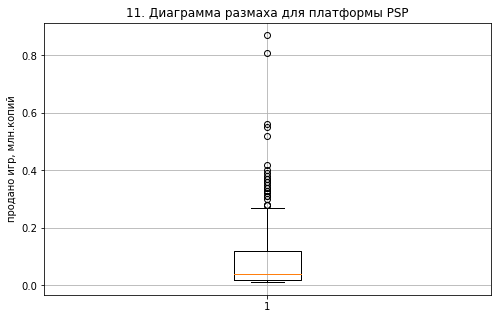

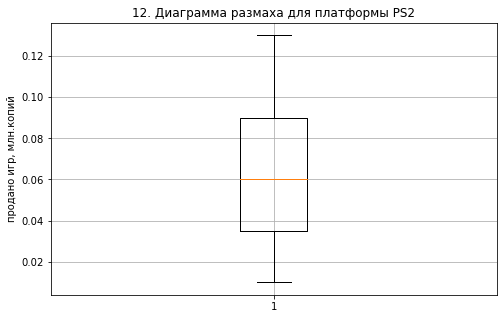

In [22]:
i = 1
for val in platform_sales.index:
    plt.figure(figsize=(8, 5))
    plt.ylabel('продано игр, млн.копий')
    plt.grid(True)
    plt.boxplot(games_aktuality.query('platform == @val')['sales'])
    plt.title(str(i)+'. Диаграмма размаха для платформы '+val)
    plt.show()
    i = i + 1

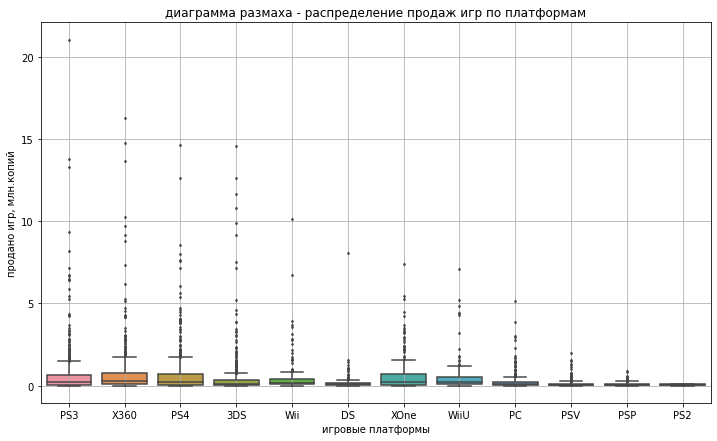

In [23]:
plt.figure(figsize=(12, 7))
plt.title('диаграмма размаха - распределение продаж игр по платформам')

sns.boxplot(x='platform', y='sales', data=games_aktuality, fliersize=2)
plt.xlabel('игровые платформы')
plt.ylabel('продано игр, млн.копий')
plt.grid(True)
plt.show()

Диаграммы размаха для большинства игровых платформ, особенно для лидеров продаж, показывают, что абсолютное большинство игр имеют невысокие продажи. Игры с высокими продажами - исключение из правил, в выборке являются выбросами. Это нормально. Хитов продаж всегда значительно меньше, чем основной массы продукции.

Распределены правильно продажи игр для самых непопулярных игоровых платформ. На них хитовых игр либо совсем мало, либо - вообще отсутствуют. 

#### 3.4. Влияние оценок критиков и пользователей на продажи игр. 

Рассмотрим, как влияют эти критерии на число проданных копий игр для самой популярной игровой платформы X360. После чего сравним эти параметры с набирающей обороты платформой для компьютерных игр XOne.     

*******************************************************

оценки критиков - влияние на продажи

------------------------------------------------------
корреляция параметров для X360 0.3912533245484556
корреляция параметров для XOne 0.4169983280084016
------------------------------------------------------



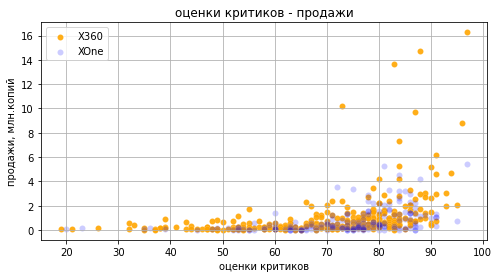

*******************************************************

оценки пользователей - влияние на продажи

------------------------------------------------------
корреляция параметров для X360 0.03891817072910259
корреляция параметров для XOne -0.06892505328279416
------------------------------------------------------



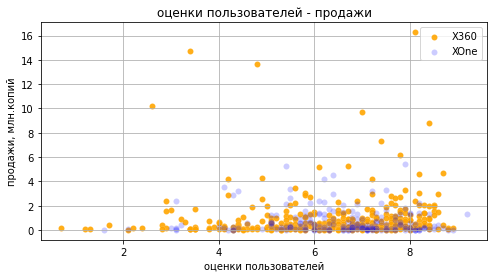

*******************************************************


In [24]:
header = ['оценки критиков', 'оценки пользователей']
field = ['critic_score', 'user_score']
platform = ['X360', 'XOne']

print('*******************************************************')
for i in range(0, len(header)):
    print()
    print(header[i], '- влияние на продажи')
    print()
    
    print('------------------------------------------------------')
    t = ['', '']
    for j in range(0, len(platform)):
        val = platform[j]
        t[j]  = games_aktuality.query('platform == @val')
        print('корреляция параметров для', platform[j], t[j]['sales'].corr(t[j][field[i]]))
    print('------------------------------------------------------')
    print()
    
    plt.figure(figsize=(8, 4))
    plt.title(header[i]+' - продажи')
    plt.xlabel(header[i])
    plt.ylabel('продажи, млн.копий')
    plt.grid(True)
    
    plt.scatter(y=t[0]['sales'], x=t[0][field[i]], color = 'orange', edgecolors = "white", linewidths = 0.1, alpha = 0.9)
    plt.scatter(y=t[1]['sales'], x=t[1][field[i]], color = 'blue', edgecolors = "white", linewidths = 0.1, alpha = 0.2)
    plt.legend(platform, loc=0)
    plt.show()    
        
    print('*******************************************************')

Оценки критиков влияют на продаваемость игр, как для раскручинной игровой платформы X360, так и для набирающей обороты XOne. Корреляция для обеих практически одинаковая 39 и 42 процента соответственно. Диаграмма рассевания не подтверждает чётковыраженной прямой зависимости для обеих платформ. Для слабо продаваемых игр оценки критиков могут быть как очень низкие, так и очень высокие. Однако, самые продаваемые игры практически всегда имеют высокие оценки критиков.

С оценками  пользователей ситуация другая. Корреляция между этим параметром и продажами практически отсутствует, а для XOne можно наблюдать очень слабую обратную зависимость. Диаграмма рассеивания подтверждает отсутстве зависимости между двумя этими параметрами.

#### 3.5 Игры каких жанров продаются лучше.

##### распределение игр по жанрам:

genre
Action          31.551467
Role-Playing    11.561412
Adventure       10.193933
Sports           9.671805
Misc             9.323720
Shooter          8.180010
Racing           4.475385
Fighting         3.953257
Simulation       3.381402
Platform         3.033317
Strategy         2.909000
Puzzle           1.765291
Name: name, dtype: float64

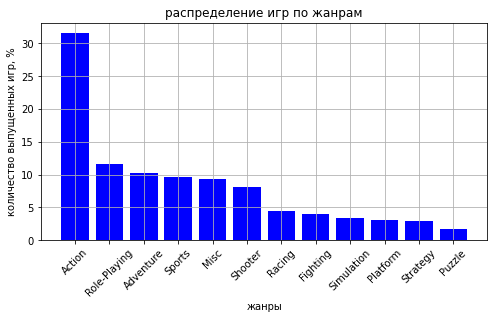

In [25]:
genre_games = games_aktuality.groupby('genre')['name'].count().sort_values(ascending=False)
genre_games = (genre_games / genre_games.sum()) * 100
display(genre_games)

plt.figure(figsize=(8, 4))
plt.xlabel('жанры')
plt.ylabel('количество выпущенных игр, %')
plt.title('распределение игр по жанрам')
plt.grid(True)
plt.bar(genre_games.index, genre_games, color='blue')
plt.xticks(rotation=45)
plt.show()

Таким образом, за актуальный период больше всего игр, с большим отрывом от других жанров, выпустилось в жанре Action. Меньше всего - в жанрах Strategy и Puzzle.                    

##### Продажи игр по жанрам:

Продажи для каждого жанра лучше отбразить в процентах от общего числа продаж, после чего построи столбчатую диаграмму.

genre
Action          28.544964
Shooter         20.618594
Role-Playing    12.569917
Sports          12.135960
Misc             7.134706
Platform         4.538127
Racing           4.519193
Fighting         3.423553
Simulation       2.572015
Adventure        2.304886
Strategy         1.134020
Puzzle           0.504066
Name: sales, dtype: float64

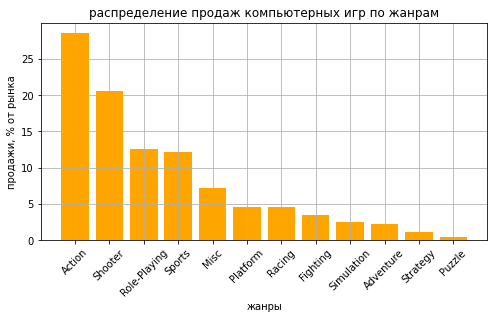

In [26]:
genre_sales = games_aktuality.groupby('genre')['sales'].sum().sort_values(ascending=False)
genre_sales = (genre_sales / genre_sales.sum()) * 100
display(genre_sales)

plt.figure(figsize=(8, 4))
plt.bar(genre_sales.index, genre_sales, color = 'orange')
plt.title('распределение продаж компьютерных игр по жанрам')
plt.xlabel('жанры')
plt.ylabel('продажи, % от рынка')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

таким образом, за актуальный период больше всего продаж у жанра Action - целых 29% от рынка, хуже всего продаются игры жанра Puzzle - 0,5% от отрынка.

##### итоговая таблица продаж игр по жанрам

,index,genre,name,sales,popularity
5,8,Shooter,329,402.91,1.224650
9,4,Platform,122,88.68,0.726885
3,10,Sports,389,237.15,0.609640
1,7,Role-Playing,465,245.63,0.528237
6,6,Racing,180,88.31,0.490611
0,0,Action,1269,557.80,0.439559
7,2,Fighting,159,66.90,0.420755
4,3,Misc,375,139.42,0.371787
8,9,Simulation,136,50.26,0.369559
10,11,Strategy,117,22.16,0.189402


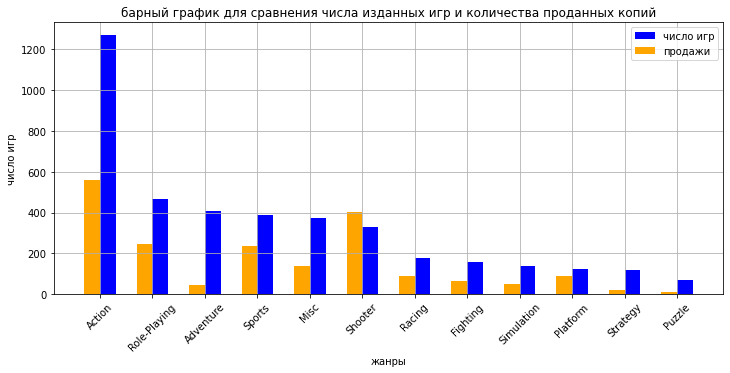

In [27]:
g_n = games_aktuality.groupby('genre')['name'].count().reset_index()
g_s = games_aktuality.groupby('genre')['sales'].sum().reset_index()

genre_result = g_n.merge(g_s, on='genre').sort_values(by='name', ascending=False).reset_index()
genre_result['popularity'] = genre_result['sales'] / genre_result['name']
display(genre_result.sort_values(by='popularity', ascending=False))

x = genre_result.index

width = 0.3

plt.figure(figsize=(12, 5))
plt.grid(True)
plt.bar(x + width/2, genre_result['name'], width, color='blue', label='число игр')
plt.bar(x - width/2, genre_result['sales'], width, color='orange', label='продажи')
plt.xticks(x, genre_result['genre'])
plt.title('барный график для сравнения числа изданных игр и количества проданных копий')
plt.xlabel('жанры')
plt.ylabel('число игр')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()

1. Cводная таблица и барный график показывают, что чем больше в каком-то жанре игр выпустили, тем больше копий продали.
2. Из сводной таблицы видно, что соотношение продаж к числу выпущенных игр по жанрам, популярность, в актуальном периоде по жанрам сильно различается. Получается, что больше прибыли приносят игры жанра Shooter и Platform, меньше всего - в жанрах  Adventure и Puzzle. Игры жанра Action, лидера по числу выпущенных и проданных игр, по прибыльности одной игры расположены в середине рейтинга.

## 4. Портрет пользователя для каждого региона.

Северная Америка - портрет пользователя

самые популярные платформы:


platform
X360    33.374045
PS3     24.759775
PS4     16.001295
XOne    13.702783
3DS     12.162103
Name: na_sales, dtype: float64

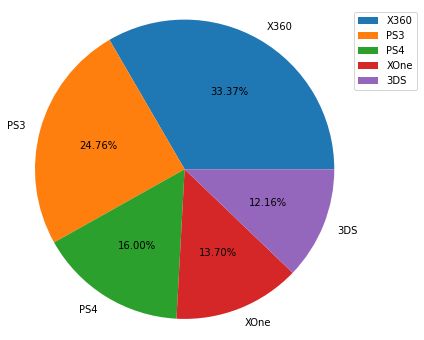


самые популярные жанры:


genre
Action          33.587387
Shooter         28.279905
Sports          15.810449
Role-Playing    12.185827
Misc            10.136432
Name: na_sales, dtype: float64

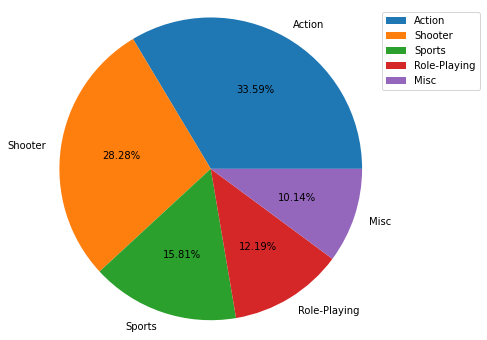

**********************************************************************

Европа - портрет пользователя

самые популярные платформы:


platform
PS3     30.245151
PS4     26.163632
X360    21.714943
3DS     11.361866
PC      10.514409
Name: eu_sales, dtype: float64

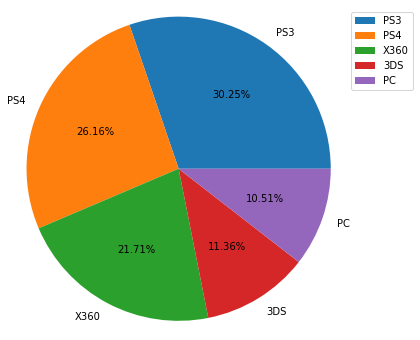


самые популярные жанры:


genre
Action          36.976787
Shooter         27.487465
Sports          16.430826
Role-Playing    11.569174
Racing           7.535747
Name: eu_sales, dtype: float64

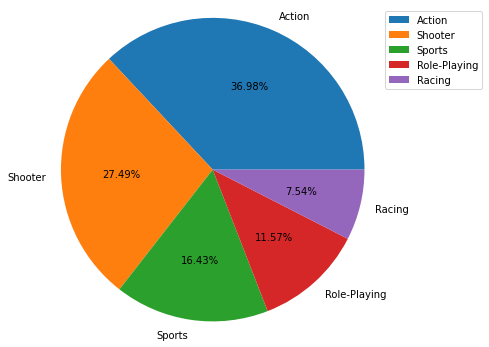

**********************************************************************

Япония - портрет пользователя

самые популярные платформы:


platform
3DS    47.495870
PS3    23.313665
PSP    11.347652
PSV    10.309181
PS4     7.533632
Name: jp_sales, dtype: float64

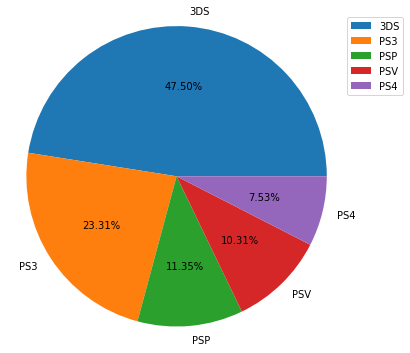


самые популярные жанры:


genre
Role-Playing    43.033405
Action          34.278017
Misc             9.482759
Fighting         6.670259
Platform         6.535560
Name: jp_sales, dtype: float64

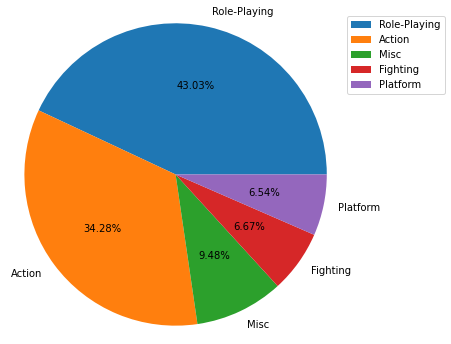

**********************************************************************



In [28]:
region = ['na_sales', 'eu_sales', 'jp_sales']
region_name = ['Северная Америка', 'Европа', 'Япония']

par = ['platform', 'genre']
par_name = ['платформы', 'жанры']

for i in range(0, len(region)):
    print(region_name[i], '- портрет пользователя')
    for j in range(0, len(par)):
        print()
        print('самые популярные', par_name[j]+':')

        table = games_aktuality.groupby(par[j])[region[i]].sum().sort_values(ascending=False).head()
        table = (table / table.sum()) * 100
        display(table)

        plt.figure(figsize=(6, 6))
        plt.pie(table, labels=table.index, autopct='%1.2f%%')
        plt.axis('equal')
        plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
        plt.show()
    print('**********************************************************************')
    print()

В результате исследования получены следующие портреты пользователя по регионам мира в принятом актуальном периоде:

1. Северная Америка - наиболее популярная игровая платформа Х360 - доля продаж 33% - третья часть от всех копий проданных игр. Замыкает спислок 3DS - 12%. Ситуация по жанрам - лидируют Action и Shooter, замыкают ТОП-5 - Role-Playing и Misk.
2. Европа - по проданным копиям игр из игровых платформ лидирует PS3 - 30%, игры для Х360 тоже хорошо продаётся - 22% от рынка ТОП-5. Замыкает рейтинг PC - 11%. Ситуация по жанрам - схожая с Северной Америкой - так же лидируют Action и Shooter, замыкает ТОП-5 - Racing.     
3. Япония - распределение продаж игр для разных платформ координально отличается от Европы и Северной Америки: лидеры 3DS и PS3 с долями продаж 47% и 23% соответственно. Ситуация по жанрам - лидируют Role-Playing - большой отрыв от всех других жанров - 43% продаваемых игр, и Action - 34%. Замыкает рейтинг Platform - 7%.

Таким образом, список популярных игровых платформ схож у Северной Америки Европы - это X360 и различные версии плэй стайшн, и сильно отличается от Японии. Та же самая ситуация и с жанрами продаваемых игр - схожая в Европе и Северной Америке и отличается в Японии. 

### Влияние рейтинга ESRB на продажи в отдельном регионе.

для исследования этого вопроса сведём данные по продажам в регионах мира по рейтингу и на её основании построим столбчатые графики для всех указанных регионов на одном рисунки. После чего сделаем соответствующие выводы. 

Основанием для сводной таблицы послужат данные из Северной Америке, так как ESRB действует на её территории.

,rating,na_sales,eu_sales,jp_sales
0,M,308.45,250.26,26.14
1,E,170.17,141.73,36.68
2,absent,123.69,116.64,138.21
3,E10+,117.72,78.00,11.23
4,T,109.31,83.16,33.39
5,EC,0.42,0.00,0.00


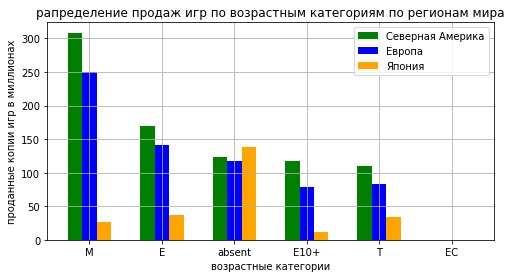

In [29]:
# создание результирующей таблицы
table_esrb = games_aktuality.groupby('rating')['na_sales'].sum().sort_values(ascending=False).reset_index()
table_eu = games_aktuality.groupby('rating')['eu_sales'].sum().reset_index()
table_jp = games_aktuality.groupby('rating')['jp_sales'].sum().reset_index()

table_esrb = table_esrb.merge(table_eu, on='rating', how='outer')
table_esrb = table_esrb.merge(table_jp, on='rating', how='outer')

display(table_esrb)

#построение барного графика
plt.figure(figsize=(8, 4))

x = table_esrb.index
width = 0.2

plt.bar(x - width, table_esrb['na_sales'], width, color='green', label='Северная Америка')
plt.bar(x, table_esrb['eu_sales'], width, color='blue', label='Европа')
plt.bar(x + width, table_esrb['jp_sales'], width, color='orange', label='Япония')
plt.xticks(x, table_esrb['rating'])
plt.title('рапределение продаж игр по возрастным категориям по регионам мира')
plt.xlabel('возрастные категории')
plt.ylabel('проданные копии игр в миллионах')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

Таким образом, по результатам изучения продаж игр по возрастным категорям в принятом актуальном периоде можно сделать следующие выводы:
1. Продажи игр в Северной Америке и Европе зависят от их возрастной категории: больше всего прдано игр категории М - игры с элементами насилия, кровью, черным юмором и крепкими выражениями. Возрастной ценз — 17 и более лет. Замыкает рейтинг игры категории ЕС - для детей от 3-х лет, что говорит о возрасте среднего пользователя - взрослые люди возрастом старше 17-ти лет.
2. Игры с неопределённой возрастной категорией в этих регионах так-же продаются, их число продаж от других категорий не отличается координально.
3. В Японии - ситуация отличается координально - больше всего продаётся игр с неопределённой возрастной категорией, продажи которых в разы больше, чем у игр, возрастная категория которых определена. Продажи по определённым возрастным категориям между собой различаются не сильно.

## 5. Проверка гипотез.

При формировании гипотез нужно исходить из того, что нулевая гипотеза всегда формулируется так, чтобы использовался знак равенства. В нулевой гипотезе все значения, полученные эмпирически, не являются экстремальными, а лежат там, где ожидаем их найти.

Для проверки использовался срез данных из колонки user_score - оценка пользователями игры, из которого исключены пропуски. По сути - данные в этой колонке и являются средними пользовательскими рейтингами той или иной игры для конкретной платформы.

Уровень статистической значимости alpha примем 5% - 0.05.

Примем, что приведённая выборка является генеральной, поэтому - атрибут ddof=1 в расчётах использоваться не будет.

### 5.1. Вопрос 1:  средние пользовательские рейтинги платформ Xbox One и PC одинаковые?

Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC равны.

Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC различаются.

In [30]:
alpha = 0.05

XOne = 'XOne'
#arr_1 = games_aktuality.query('platform == @XOne and not user_score.isnull()')['user_score']
arr_1 = games_aktuality.loc[(games_aktuality['platform'] == XOne) & (games_aktuality['user_score'].notnull())]['user_score']

PC = 'PC'
#arr_2 = games_aktuality.query('platform == @PC and not user_score.isnull()')['user_score']
arr_2 = games_aktuality.loc[(games_aktuality['platform'] == PC) & (games_aktuality['user_score'].notnull())]['user_score']


#проверка дисперсий выборок:
variance_1 = np.var(arr_1)
print('дисперсия для XOne:', variance_1)
variance_2 = np.var(arr_2)
print('дисперсия для PC:', variance_2)

difference = (math.fabs(variance_1 - variance_2) / variance_2) * 100

print('дисперсии выборок различаются на ', str(difference)+'%')

print()

# примем, что дисперсии выборок значительно различаются, поэтому параметр метода st.ttest_ind() "equal_var" принимаем  False 

result = st.ttest_ind(arr_1, arr_2, equal_var = False)

print('значение pvalue:', result.pvalue)

if result.pvalue < alpha:
    print('нулевая гипотеза отвергнута, средние пользовательские рейтинги платформ Xbox One и PC различаются')
else:
    print('нулевая гипотеза подтверждена,  средние пользовательские рейтинги платформ Xbox One и PC одинаковые')

дисперсия для XOne: 1.8965188383045533
дисперсия для PC: 2.587838809960847
дисперсии выборок различаются на  26.714182081022003%

значение pvalue: 0.6130712247638477
нулевая гипотеза подтверждена,  средние пользовательские рейтинги платформ Xbox One и PC одинаковые


### 5.2. Вопрос 2: средние пользовательские рейтинги жанров Action и Sports разные?

Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports равны.
Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports различаются.

In [31]:
alpha = 0.05

action = 'Action'
#arr_1 = games_aktuality.query('genre == @action and not user_score.isnull()')['user_score']
arr_1 = games_aktuality.loc[(games_aktuality['genre'] == action) & (games_aktuality['user_score'].notnull())]['user_score']

sports = 'Sports'
#arr_2 = games_aktuality.query('genre == @sports and not user_score.isnull()')['user_score']
arr_2 = games_aktuality.loc[(games_aktuality['genre'] == sports) & (games_aktuality['user_score'].notnull())]['user_score']


#проверка дисперсий выборок:
variance_1 = np.var(arr_1)
print('дисперсия для Action:', variance_1)
variance_2 = np.var(arr_2)
print('дисперсия для Sports:', variance_2)

difference = (math.fabs(variance_1 - variance_2) / variance_2) * 100

print('дисперсии выборок различаются на ', str(difference)+'%')

print()

# примем, что дисперсии выборок значительно различаются, поэтому параметр метода st.ttest_ind() "equal_var" принимаем  False 

result = st.ttest_ind(arr_1, arr_2, equal_var = False)

print('значение pvalue:', result.pvalue)

if result.pvalue < alpha:
    print('нулевая гипотеза отвергнута, средние пользовательские рейтинги жанров Action и Sports различаются')
else:
    print('нулевая гипотеза подтверждена, средние пользовательские рейтинги жанров Action и Sports равны')

дисперсия для Action: 1.8091482798664522
дисперсия для Sports: 2.8707920219446086
дисперсии выборок различаются на  36.98086569709161%

значение pvalue: 8.285648549432565e-19
нулевая гипотеза отвергнута, средние пользовательские рейтинги жанров Action и Sports различаются


## Общий вывод.

Входе проведённого исследования получены следующие выводы и рекомендации для формирование ассортимента магазина:
1. Популярность игры в наступающем 2017 году будет напрямую зависить от её принадлежности к жанру, игровой платформе, годом выпуска, что определяется историческими данными о продажах.
2. Самыми популярными игровыми платформами в актуальном периоде являются PS3  - 445.57 млн. проданных копий, X360 - 380.38, PS4 - 314.14 соответственно - это наиболее раскрученные, известные игрокам платформы, на которых выпущено большое количество хитовых игр. Однако, PS3 и X360 - достаточно старые. Их жизненный цикл подходит к завершению, и надеяться на значительные продажи игр для них в 2017 году не приходится.
3. Существуют свежие игровые платформы - WiiU, PS4, XOnе, возрастом 4-5 лет. Они ещё не достаточно не раскручены, многие из них по продажам даже не вошли в ТОП-5. Но игр для этих платформ с каждым годом выпускается всё больше, их продажи, в отличие от общей тенденции, с годами не падают, а в некоторых случаях, как например для PS4 - растут. Именно эти платформы в 2017 году будут популярны, спрос на них будет расти. 
4. Больше всего игр продаётся в жанрах Action - 29% от рынка - большой отрыв от всех других жанров, Shooter - 21%. Таким образом, при формировании ассортимента магазина логично обратить внимание именно на эти жанры. Кроме этого, игры жанра Shooter по числу продаж на одну игру, следовательно - по популярности, стоят на первом месте.
5. Игр 2011 года выпуска продано больше, чем выпущенных в других годах. Это, опять же, объясняется раскрученностью. За указанный срок игра становиться популярной и не успевает устареть.
6. Популярностью пользуется возрастная категория М - игры с элементами насилия, кровью, черным юмором и крепкими выражениями. Возрастной ценз — 17 и более лет. В Японии наиболее популярны игры, возрастной рейтинг которых не определён. Это так же нужно учесть в разработке рекламных компаний для региона.
7. При формировании аудитории для рекламы логично обратить внимание на портреты среднего пользователя по регионам мира. Если популярные игровые платформы и жанры для Северной Америки и Европы похожи - это игры для платформ X360 и PS различных модификаций, жанры Action и Shooter, то для Японии - эти параметры серьёзно отличаются - там необходимо рекламировать игровую платформу 3DS и жанр Role-Playing.  
8. В Северной Америке и Европе больше всего продано компьютерных игр. Поэтому, основная реклама должна ориентироваться на англоязычный сектор Сети.
9. Зависимость продаж от такие характеристик, как оценки пользователей и критиков входе исследования не нашла подтверждения. Поэтому, ориентироваться на них при планировании рекламных компаний не стоит.  